In [1]:
# SYSTEM
from os import sys, cpu_count
from time import time
from multiprocessing import Process
from multiprocessing.shared_memory import SharedMemory

# DATA TOOLS
import pickle
import numpy as np
import pandas as pd
#import scipy as sp
import scipy.stats as stats
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler#, PolynomialFeatures
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans#, MeanShift
from sklearn.linear_model import  LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.svm import SVR

# VISUALIZATION
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# PACKAGE CONFIG
mpl.rcParams.update({'font.size':16})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('./input/train.csv')

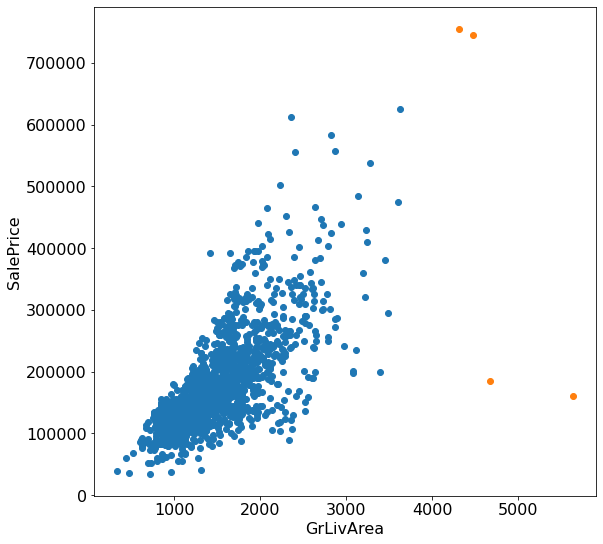

In [3]:
X = df.GrLivArea[df.GrLivArea < 4000]
y = df.SalePrice[df.GrLivArea < 4000]
Xo = df.GrLivArea[df.GrLivArea > 4000]
yo = df.SalePrice[df.GrLivArea > 4000]
plt.figure(figsize=(9,9))
plt.scatter(X,y, c = 'C0')
plt.scatter(Xo,yo, c='C1')
plt.xlabel(X.name)
plt.ylabel(y.name)
plt.show()

df = df[(df['GrLivArea'] < 4000)]

In [4]:
df['SalePrice'] = np.log1p(df['SalePrice'])
target = df['SalePrice']

fig, ax = plt.subplots(figsize= (9,9))
stats.probplot(target,plot=ax)
plt.show()

# Missing Values 

plt.figure(figsize=(32,18))
sns.heatmap(df.isnull())
plt.tick_params(left=False,
                labelleft=False)
plt.show()

df.columns[df.isnull().any() == True]

## Missingness

X = df.YearBuilt
y = df.GarageYrBlt
plt.figure(figsize=(9,9))
plt.scatter(X,y, c = 'C0')
plt.xlim(1870,2020)
plt.ylim(1870,2020)
plt.xlabel(X.name)
plt.ylabel(y.name)
plt.show()


In [5]:
df[df.GarageYrBlt.isnull() & df.GarageType.isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,40,90,RL,65.000,6040,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,11.314
48,49,190,RM,33.000,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,11.635
78,79,90,RL,72.000,10778,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.824
88,89,50,C (all),105.000,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,11.350
89,90,20,RL,60.000,8070,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,11.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1350,70,RM,50.000,5250,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,11.712
1407,1408,20,RL,nan,8780,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2009,WD,Normal,11.626
1449,1450,180,RM,21.000,1533,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml,11.430
1450,1451,90,RL,60.000,9000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,11.820


In [6]:
# NA probably means no frontage
df['LotFrontage'].replace(np.nan,0,inplace=True)

# NA probably means no alley
df['Alley'].replace(np.nan,'None',inplace=True)

# NA probably means no basement
df['BsmtQual'].replace(np.nan,'None',inplace=True)
df['BsmtCond'].replace(np.nan,'None',inplace=True)
df['BsmtExposure'].replace(np.nan,'None',inplace=True)
df['BsmtFinType1'].replace(np.nan,'None',inplace=True)
df['BsmtFinType2'].replace(np.nan,'None',inplace=True)

# Replaced with feature mode
df['Electrical'].replace(np.nan,stats.mode(df['Electrical'])[0][0],inplace=True)

# NA probably means no fence
df['Fence'].replace(np.nan,'None',inplace=True)

# NA probably means no fireplaces
df['FireplaceQu'].replace(np.nan,'None',inplace=True)

# NA probably means no garage
df['GarageType'].replace(np.nan,'None',inplace=True)
df['GarageFinish'].replace(np.nan,'None',inplace=True)
df['GarageQual'].replace(np.nan,'None',inplace=True)
df['GarageCond'].replace(np.nan,'None',inplace=True)

# Best choice is not clear. 
df['GarageYrBlt'].replace(np.nan,df['YearBuilt'],inplace=True)

# NA probably means no Masonry Veneer
df['MasVnrArea'].replace(np.nan,0,inplace=True)
df['MasVnrType'].replace(np.nan,'None',inplace=True)

# NA probably means no misc feature
df['MiscFeature'].replace(np.nan,'None',inplace=True)

# NA probably means there is no pool
df['PoolQC'].replace(np.nan,'None',inplace=True)

# Was anything missed?
df.columns[df.isnull().any() == True]

Index([], dtype='object')

In [7]:
df['MSSubClass'] = df['MSSubClass'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [8]:
df.replace({'Alley':{'None':0,'Grvl':1,'Pave':2},
            'Street':{'Grvl':1,'Pave':2},
            'LandContour':{'Low':1,'HLS':2,'Bnk':3,'Lvl':4},
            'LandSlope':{'Sev':1,'Mod':2,'Gtl':3},
            'ExterQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'ExterCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtExposure':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtFinType1':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
            'BsmtFinType2':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
            'HeatingQC':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'CentralAir':{'N':0,'Y':1},
            'Electrical':{'Mix':1,'FuseP':2,'FuseF':3,'FuseA':4,'SBrkr':5},
            'KitchenQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'Functional':{'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8},
            'FireplaceQu':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'GarageFinish':{'None':0,'Unf':1,'RFn':2,'Fin':3},
            'GarageQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'GarageCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'PavedDrive':{'N':0,'P':1,'Y':2},
            'PoolQC':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
           },inplace=True)

In [9]:
df['BasicOverallQual'] = df['OverallQual'].replace({1:1,2:1,3:1,
                                                    4:2,5:2,6:2,
                                                    7:3,8:3,9:3,10:3})
df['BasicOverallCond'] = df['OverallCond'].replace({1:1,2:1,3:1,
                                                    4:2,5:2,6:2,
                                                    7:3,8:3,9:3,10:3})
df['BasicExterQual'] = df['ExterQual'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
df['BasicExterCond'] = df['ExterCond'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
df['BasicBsmtQual'] = df['BsmtQual'].replace({0:1,1:1,
                                              2:2,3:2,
                                              4:3,5:3})
df['BasicBsmtCond'] = df['BsmtCond'].replace({0:1,1:1,
                                              2:2,3:2,
                                              4:3,5:3})
df['BasicBsmtExposure'] = df['BsmtExposure'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
df['BasicBsmtFinType1']  = df['BsmtFinType1'].replace({0:1,1:1,
                                                       2:2,3:2,
                                                       4:3,5:3})
df['BasicBsmtFinType2']  = df['BsmtFinType2'].replace({0:1,1:1,
                                                       2:2,3:2,
                                                       4:3,5:3})
df['BasicHeatingQC'] = df['HeatingQC'].replace({0:1,1:1,
                                                2:2,3:2,
                                                4:3,5:3})
df['BasicElectrical'] = df['Electrical'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
df['BasicKitchenQual'] = df['KitchenQual'].replace({0:1,1:1,
                                                     2:2,3:2,
                                                     4:3,5:3})
df['BasicFunctional'] = df['Functional'].replace({1:1,2:1,3:1,
                                                  4:2,5:2,6:2,
                                                  7:3,8:3,9:3,10:3})
df['BasicFireplaceQu'] = df['FireplaceQu'].replace({0:1,1:1,
                                                        2:2,3:2,
                                                        4:3,5:3})
df['BasicGarageQual'] = df['GarageQual'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
df['BasicGarageCond'] = df['GarageCond'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
df['BasicPoolQC'] = df['PoolQC'].replace({0:1,1:1,
                                          2:2,3:2,
                                          4:3,5:3})


In [10]:
# Full grades & scores
df['OverallGrade'] = df['OverallQual']*df['OverallCond']
df['ExterGrade'] = df['ExterQual']*df['ExterCond']
df['GarageGrade'] = df['GarageQual']*df['GarageCond']
df['GarageQScore'] = df['GarageArea']*df['GarageQual']
df['GarageCScore'] = df['GarageArea']*df['GarageCond']
df['KitchenScore'] = df['KitchenAbvGr']*df['KitchenQual']
df['FireplaceScore'] = df['Fireplaces']*df['FireplaceQu']
df['PoolScore'] = df['PoolArea']*df['PoolQC']

# Basic grades & scores
df['BasicOverallGrade'] = df['BasicOverallQual']*df['BasicOverallCond']
df['BasicExterGrade'] = df['BasicExterQual']*df['BasicExterCond']
df['BasicGarageGrade'] = df['BasicGarageQual']*df['BasicGarageCond']
df['BasicGarageQscore'] = df['GarageArea']*df['BasicGarageQual']
df['BasicGarageCscore'] = df['GarageArea']*df['BasicGarageCond']
df['BasicKitchenScore'] = df['KitchenAbvGr']*df['BasicKitchenQual']
df['BasicFireplaceScore'] = df['Fireplaces']*df['BasicFireplaceQu']
df['BasicPoolScore'] = df['PoolArea']*df['BasicPoolQC']


df['TotalBath'] = df['FullBath'] + df['BsmtFullBath'] + (0.5)*(df['HalfBath'] + df['BsmtHalfBath'])
df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
df['TotalFlrsSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['3SsnPorch']

In [11]:
print("Find most important features relative to target")
corr = df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice[0:11])
#for ind, each in zip(corr.index, corr.SalePrice):
#    print(f'df[\'{ind}-rt\'] = np.sqrt(df[\'{ind}\'])')
#    print(f'df[\'{ind}-2\'] = np.power(df[\'{ind}\'],2)')
#    print(f'df[\'{ind}-3\'] = np.power(df[\'{ind}\'],3)')

Find most important features relative to target
SalePrice          1.000
OverallQual        0.819
TotalSF            0.817
TotalFlrsSF        0.729
GrLivArea          0.719
BasicOverallQual   0.708
ExterQual          0.681
GarageCars         0.680
TotalBath          0.673
KitchenQual        0.667
GarageQScore       0.657
Name: SalePrice, dtype: float64


In [12]:
df['OverallQual-rt'] = np.sqrt(df['OverallQual'])
df['OverallQual-2'] = np.power(df['OverallQual'],2)
df['OverallQual-3'] = np.power(df['OverallQual'],3)
df['TotalSF-rt'] = np.sqrt(df['TotalSF'])
df['TotalSF-2'] = np.power(df['TotalSF'],2)
df['TotalSF-3'] = np.power(df['TotalSF'],3)
df['TotalFlrsSF-rt'] = np.sqrt(df['TotalFlrsSF'])
df['TotalFlrsSF-2'] = np.power(df['TotalFlrsSF'],2)
df['TotalFlrsSF-3'] = np.power(df['TotalFlrsSF'],3)
df['GrLivArea-rt'] = np.sqrt(df['GrLivArea'])
df['GrLivArea-2'] = np.power(df['GrLivArea'],2)
df['GrLivArea-3'] = np.power(df['GrLivArea'],3)
df['BasicOverallQual-rt'] = np.sqrt(df['BasicOverallQual'])
df['BasicOverallQual-2'] = np.power(df['BasicOverallQual'],2)
df['BasicOverallQual-3'] = np.power(df['BasicOverallQual'],3)
df['ExterQual-rt'] = np.sqrt(df['ExterQual'])
df['ExterQual-2'] = np.power(df['ExterQual'],2)
df['ExterQual-3'] = np.power(df['ExterQual'],3)
df['GarageCars-rt'] = np.sqrt(df['GarageCars'])
df['GarageCars-2'] = np.power(df['GarageCars'],2)
df['GarageCars-3'] = np.power(df['GarageCars'],3)
df['TotalBath-rt'] = np.sqrt(df['TotalBath'])
df['TotalBath-2'] = np.power(df['TotalBath'],2)
df['TotalBath-3'] = np.power(df['TotalBath'],3)
df['KitchenQual-rt'] = np.sqrt(df['KitchenQual'])
df['KitchenQual-2'] = np.power(df['KitchenQual'],2)
df['KitchenQual-3'] = np.power(df['KitchenQual'],3)
df['GarageQScore-rt'] = np.sqrt(df['GarageQScore'])
df['GarageQScore-2'] = np.power(df['GarageQScore'],2)
df['GarageQScore-3'] = np.power(df['GarageQScore'],3)

In [13]:
categoric = df.select_dtypes(include="object").columns
numeric = df.select_dtypes(exclude="object").columns
numeric.drop('SalePrice')

df_n = df.loc[:,numeric]
df_c = df.loc[:,categoric]

In [14]:
skewness = df_n.apply(lambda x: stats.skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
df_n[skewed_features] = np.log1p(df_n[skewed_features])

In [15]:
df_c = pd.get_dummies(df_c)
df_model = pd.concat([df_n,df_c],axis=1)
df_model.shape

(1456, 327)

#  Basic Model

94


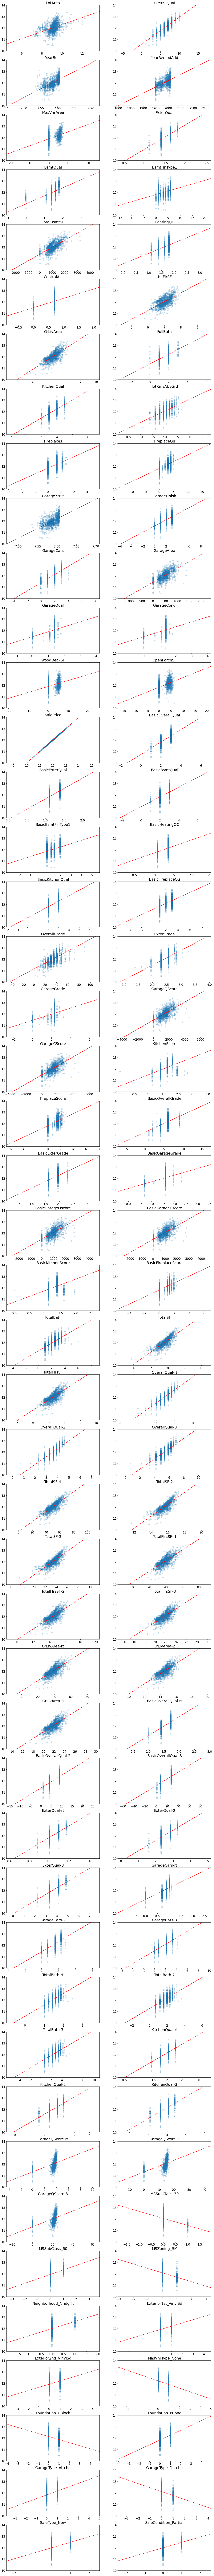

In [16]:
features = list(df_model.columns)
best_features = list()
j=0
fig, axs = plt.subplots(figsize=(16,800))
fig.tight_layout()

for i in range(0,len(features)):
    #r, p = stats.pearsonr(df_model[features[i]],df_model['adjprice'])
    slope, intercept, r, p, std_err = stats.linregress(df_model[features[i]],target)
    if (p < 0.05) & (np.sqrt(r**2) > 0.33):
        #print('{:<4d}{:<25s}{:>10f}{:>12f}'.format(i,features[i],r,p))
        j=j+1
        best_features.append(features[i])
        devs = 9
        xmin = np.mean(df_model[features[i]]) - devs*np.std(df_model[features[i]])
        xmax = np.mean(df_model[features[i]]) + devs*np.std(df_model[features[i]])
        domain = np.linspace(-1e9,1e9,10)
        y_pred = slope*domain + intercept
        plt.subplot(200,2,j)
        plt.xlim(xmin,xmax)
        plt.ylim(10,14)
        plt.scatter(df_model[features[i]],target,alpha=0.2)
        plt.plot(domain,y_pred,c = 'r', linestyle='--',linewidth=2)
        #plt.xticks(rotation=90)
        #plt.text(xmin,10.25,
        #f' $R^2$ = {r:.2f}\
        #\n $ln$(adjprice) =\
        #\n   ({slope:.2e}){features[i]} + {intercept:.2e}\
        #\np = {p:.2e}\nstderr = {std_err:.2e}')
        plt.title(features[i])
print(j)
best_features.remove('SalePrice')


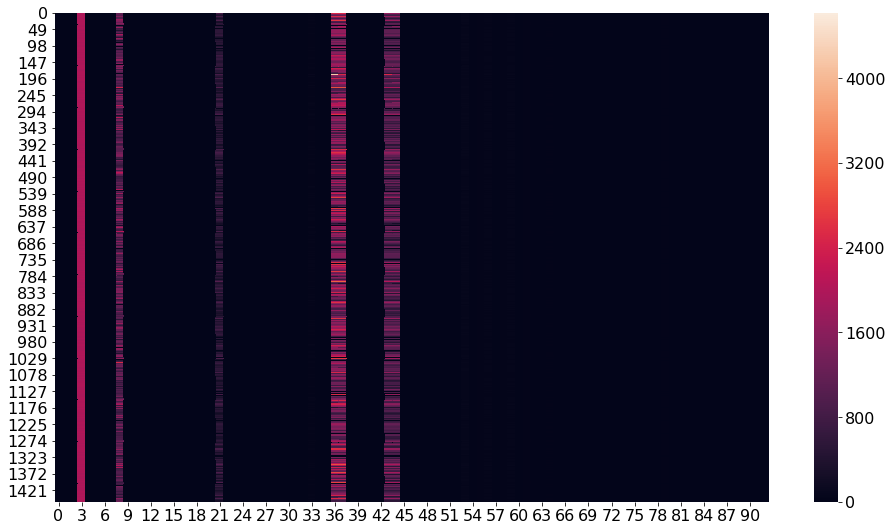

In [17]:
template = np.zeros((df_model.shape[0],df_model.loc[:,best_features].shape[1]+1),dtype=np.float64)
yX_shm = SharedMemory(create=True, size=template.nbytes)
yX = np.ndarray(template.shape, dtype=template.dtype, buffer=yX_shm.buf)

yX[:,1:] = np.array(df_model.loc[:,best_features],dtype=np.float64)[:,:]
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#yX = scaler.fit_transform(yX)
yX[:,0] = target
plt.figure(figsize=(16,9))
sns.heatmap(yX[:,1:])
plt.show()

In [18]:
# MULTIPROCESSING DEFINITIONS

"""
Given an input array, this function returns an array containing
the start positions of jobs as well as job length based on the 
number of cpus available.
"""
def divide_work(ARRAY, WORK_INDEX):
    n_cpus = cpu_count()
    job_len = np.floor(ARRAY.shape[WORK_INDEX]/n_cpus)
    work_schedule = np.zeros((n_cpus,2), dtype=np.longlong) # [(start_position),(job_length)]
    for i in range(0,n_cpus):
        distance = i*job_len
        work_schedule[i,0] =  distance 
        if i != (n_cpus - 1): # The length of the last job is dynamic 
            work_schedule[i,1] = job_len
        else:
            work_schedule[i,1] = ARRAY.shape[WORK_INDEX] - distance
    return work_schedule


def score_model(INPUT, OUTPUT, MODEL_TYPE, OFFSET, DURATION):
    X = INPUT[:,1:]
    y = INPUT[:,0]
    for i in range(0, DURATION):
        rng = np.random.default_rng()
        state = rng.integers(1e9)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = state)
        X_scaler = MinMaxScaler()
        X_train = X_scaler.fit_transform(X_train)
        X_test = X_scaler.transform(X_test)
        reg = MODEL_TYPE
        reg.fit(X_train, y_train)
        OUTPUT[0][i + OFFSET] = reg.score(X_test,y_test)
        y_pred = np.expm1(reg.predict(X_test),dtype = np.float64)
        y_actual = np.apply_along_axis(np.expm1,0,y_test)
        RMSE = np.sqrt(np.mean(y_pred - y_actual)**2)
        OUTPUT[1][i + OFFSET] = RMSE


"""
Given an input & output array, a task, and a work schedule,
this function starts a process which starts processes to 
perform the indicated task on the input array according to
the work schedule and write the output to the output array.

For more info on the "work schedule," see above
"""
def assign_work(INPUT, TASK, MODEL_TYPE, WORK_SCHEDULE, OUTPUT):
    processes = []
    for i in range(len(WORK_SCHEDULE)):
        #print(f'start {i}')
        p = Process(target=TASK, args=(INPUT,OUTPUT, MODEL_TYPE, WORK_SCHEDULE[i,0], WORK_SCHEDULE[i,1]))
        processes.append(p)
        p.start()
    for i in range(len(WORK_SCHEDULE)):
        #print(f'join {i}')
        processes[i].join()

def draw_plots(MODEL_TYPE, WORKOUTPUT, BINS):
    plt.subplots(2,1,figsize=(16,16))
    xlab = ['$R^2$','RMSE\n($USD, adjusted for inflation 2021)']
    xlims = np.array(((-1.0,1.0),
                    (0.0,20000.0)))
    for i in range(0,2):
        plt.subplot(2, 1, i + 1)
        plt.hist(WORKOUTPUT[i],bins=BINS)
        plt.title(f'{str(MODEL_TYPE)} (N={testlen:,})')
        plt.xlabel(xlab[i])
        #plt.xlim(xlims[i,0],xlims[i,1])
        plt.ylabel('Frequency')
    plt.show()

    print('========')
    print('Scores ')
    tmp = stats.describe(WORKOUTPUT[0])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'  {tmp._fields[i]}:{buf}\t{tmp[i]}')

    print('========')
    print(' Error  ')
    tmp = stats.describe(WORKOUTPUT[1])
    for i in range(len(tmp)):
        buf =  (8 - len(tmp._fields[i]))*' '
        print(f'  {tmp._fields[i]}:{buf}\t{tmp[i]}')

rng = np.random.default_rng()
state = rng.integers(1e9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = state)
X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
lasso_reg = Ridge()
param_dict = {'alpha':np.arange(1e-4,1e1,20e-4)}
grid_Lasso = GridSearchCV(lasso_reg, param_grid = param_dict, cv=10, n_jobs=-1)
grid_Lasso.fit(X_train,y_train)
grid_Lasso.best_estimator_

In [19]:
#!rm 'firstlinear.pkl'

Loaded from file!


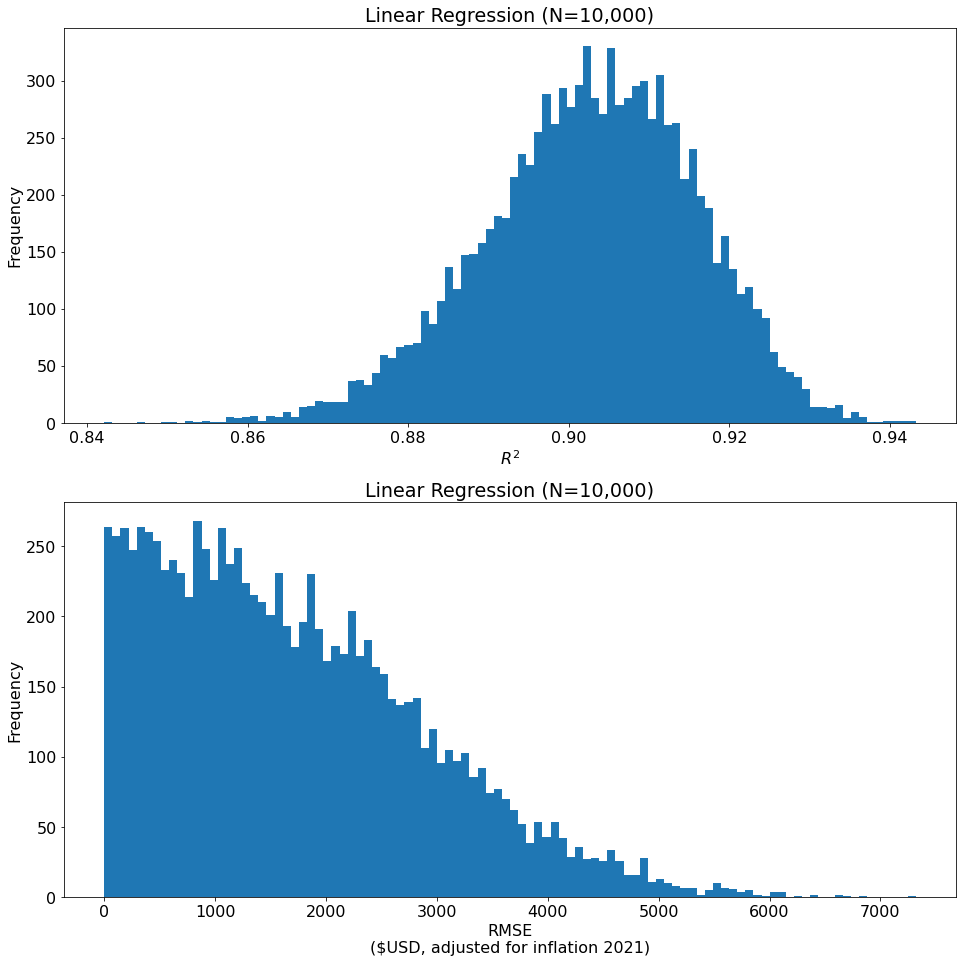

Scores 
  nobs:    	10000
  minmax:  	(0.8421461050367544, 0.9432186068332133)
  mean:    	0.9026786549835372
  variance:	0.00017470712905549664
  skewness:	-0.3289717370459728
  kurtosis:	0.09717163184907163
 Error  
  nobs:    	10000
  minmax:  	(0.04407517083975158, 7319.117852777596)
  mean:    	1707.866619701866
  variance:	1458570.59470934
  skewness:	0.7590751810132557
  kurtosis:	0.17604801928714897


In [20]:
filename = 'firstlinear.pkl'
testlen = 10000
try:
    with open(filename,'rb') as f:
        output = pickle.load(f)
        print('Loaded from file!')
except:
    print('Go!')
    start_time = time()
    template = np.zeros(testlen,dtype=np.float64)
    scores_shm = SharedMemory(create=True, size=template.nbytes)
    scores = np.ndarray(template.shape, dtype=template.dtype, buffer=scores_shm.buf)
    error_shm = SharedMemory(create=True, size=template.nbytes)
    error = np.ndarray(template.shape, dtype=template.dtype, buffer=error_shm.buf)
    lasso_reg = Lasso()
    param_dict = {'alpha':np.arange(0.1,1,0.1)}
    grid_Lasso = GridSearchCV(lasso_reg, param_grid = param_dict, cv=10)
    model = Ridge(alpha=1.1681, copy_X=True, fit_intercept=True, max_iter=None,
                  normalize=False, random_state=None, solver='auto', tol=0.001)
    output = [scores,error]
    job_list = divide_work(template, 0)
    start_time = time()
    if __name__ == '__main__':  
        assign_work(yX, score_model, model, job_list, output)
    print(f'Time Elapsed: {time() - start_time:.3f}s')
    with open(filename,'wb') as f:
        pickle.dump(output, f)
    
draw_plots('Linear Regression',output,100)

In [21]:
test =  pd.read_csv('./input/test.csv')
test.set_index('Id',inplace=True)
test.shape

(1459, 79)

plt.figure(figsize=(32,18))
sns.heatmap(test.isnull())
plt.tick_params(left=False,
                labelleft=False)
plt.show()
print(test.columns[test.isnull().any() == True])

In [22]:
# This isn't very elegant. Try to make this less brute forcey, more modular.
# It's a pretty regular task and would benefit from attention.


# NA probably means no frontage
test['LotFrontage'].replace(np.nan,0,inplace=True)

# NA probably means no alley
test['Alley'].replace(np.nan,'None',inplace=True)

# NA probably means no basement
test['BsmtQual'].replace(np.nan,'None',inplace=True)
test['BsmtCond'].replace(np.nan,'None',inplace=True)
test['BsmtExposure'].replace(np.nan,'None',inplace=True)
test['BsmtFinType1'].replace(np.nan,'None',inplace=True)
test['BsmtFinType2'].replace(np.nan,'None',inplace=True)

# Replaced with feature mode
test['Electrical'].replace(np.nan,stats.mode(df['Electrical'])[0][0],inplace=True)

# NA probably means no fence
test['Fence'].replace(np.nan,'None',inplace=True)

# NA probably means no fireplaces
test['FireplaceQu'].replace(np.nan,'None',inplace=True)

# NA probably means no garage
test['GarageType'].replace(np.nan,'None',inplace=True)
test['GarageFinish'].replace(np.nan,'None',inplace=True)
test['GarageQual'].replace(np.nan,'None',inplace=True)
test['GarageCond'].replace(np.nan,'None',inplace=True)

# Best choice is not clear. 
test['GarageYrBlt'].replace(np.nan,df['YearBuilt'],inplace=True)

# NA probably means no Masonry Veneer
test['MasVnrArea'].replace(np.nan,0,inplace=True)
test['MasVnrType'].replace(np.nan,'None',inplace=True)

# NA probably means no misc feature
test['MiscFeature'].replace(np.nan,'None',inplace=True)

# NA probably means there is no pool
test['PoolQC'].replace(np.nan,'None',inplace=True)


test['MSZoning'].replace(np.nan,stats.mode(test['MSZoning'])[0][0],inplace=True)
test['Utilities'].replace(np.nan,stats.mode(test['Utilities'])[0][0],inplace=True)
test['Exterior1st'].replace(np.nan,0,inplace=True)
test['Exterior2nd'].replace(np.nan,0,inplace=True)
test['BsmtFinSF1'].replace(np.nan,0,inplace=True)
test['BsmtFinSF2'].replace(np.nan,0,inplace=True)
test['BsmtUnfSF'].replace(np.nan,0,inplace=True)
test['TotalBsmtSF'].replace(np.nan,0,inplace=True)
test['BsmtFullBath'].replace(np.nan,0,inplace=True)
test['BsmtHalfBath'].replace(np.nan,0,inplace=True)
test['KitchenQual'].replace(np.nan,stats.mode(test['KitchenQual'])[0][0],inplace=True)
test['Functional'].replace(np.nan,stats.mode(test['Functional'])[0][0],inplace=True)
test['GarageYrBlt'].replace(np.nan,stats.mode(test['YearBuilt'])[0][0],inplace=True)
test['GarageCars'].replace(np.nan,0,inplace=True)
test['GarageArea'].replace(np.nan,0,inplace=True)
test['SaleType'].replace(np.nan,stats.mode(test['SaleType'])[0][0],inplace=True)


# Was anything missed?
print(test.columns[test.isnull().any() == True])

Index([], dtype='object')


In [23]:
test['MSSubClass'] = test['MSSubClass'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

In [24]:
test.replace({'Alley':{'None':0,'Grvl':1,'Pave':2},
            'Street':{'Grvl':1,'Pave':2},
            'LandContour':{'Low':1,'HLS':2,'Bnk':3,'Lvl':4},
            'LandSlope':{'Sev':1,'Mod':2,'Gtl':3},
            'ExterQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'ExterCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtExposure':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'BsmtFinType1':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
            'BsmtFinType2':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
            'HeatingQC':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'CentralAir':{'N':0,'Y':1},
            'Electrical':{'Mix':1,'FuseP':2,'FuseF':3,'FuseA':4,'SBrkr':5},
            'KitchenQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'Functional':{'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,'Min2':6,'Min1':7,'Typ':8},
            'FireplaceQu':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'GarageFinish':{'None':0,'Unf':1,'RFn':2,'Fin':3},
            'GarageQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'GarageCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
            'PavedDrive':{'N':0,'P':1,'Y':2},
            'PoolQC':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
           },inplace=True)

In [25]:
test['BasicOverallQual'] = test['OverallQual'].replace({1:1,2:1,3:1,
                                                    4:2,5:2,6:2,
                                                    7:3,8:3,9:3,10:3})
test['BasicOverallCond'] = test['OverallCond'].replace({1:1,2:1,3:1,
                                                    4:2,5:2,6:2,
                                                    7:3,8:3,9:3,10:3})
test['BasicExterQual'] = test['ExterQual'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
test['BasicExterCond'] = test['ExterCond'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
test['BasicBsmtQual'] = test['BsmtQual'].replace({0:1,1:1,
                                              2:2,3:2,
                                              4:3,5:3})
test['BasicBsmtCond'] = test['BsmtCond'].replace({0:1,1:1,
                                              2:2,3:2,
                                              4:3,5:3})
test['BasicBsmtExposure'] = test['BsmtExposure'].replace({0:1,1:1,
                                                      2:2,3:2,
                                                      4:3,5:3})
test['BasicBsmtFinType1']  = test['BsmtFinType1'].replace({0:1,1:1,
                                                       2:2,3:2,
                                                       4:3,5:3})
test['BasicBsmtFinType2']  = test['BsmtFinType2'].replace({0:1,1:1,
                                                       2:2,3:2,
                                                       4:3,5:3})
test['BasicHeatingQC'] = test['HeatingQC'].replace({0:1,1:1,
                                                2:2,3:2,
                                                4:3,5:3})
test['BasicElectrical'] = test['Electrical'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
test['BasicKitchenQual'] = test['KitchenQual'].replace({0:1,1:1,
                                                     2:2,3:2,
                                                     4:3,5:3})
test['BasicFunctional'] = test['Functional'].replace({1:1,2:1,3:1,
                                                  4:2,5:2,6:2,
                                                  7:3,8:3,9:3,10:3})
test['BasicFireplaceQu'] = test['FireplaceQu'].replace({0:1,1:1,
                                                        2:2,3:2,
                                                        4:3,5:3})
test['BasicGarageQual'] = test['GarageQual'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
test['BasicGarageCond'] = test['GarageCond'].replace({0:1,1:1,
                                                  2:2,3:2,
                                                  4:3,5:3})
test['BasicPoolQC'] = test['PoolQC'].replace({0:1,1:1,
                                          2:2,3:2,
                                          4:3,5:3})


In [26]:
# Full grades & scores
test['OverallGrade'] = test['OverallQual']*test['OverallCond']
test['ExterGrade'] = test['ExterQual']*test['ExterCond']
test['GarageGrade'] = test['GarageQual']*test['GarageCond']
test['GarageQScore'] = (test['GarageArea']*test['GarageQual']).astype(np.float64)
test['GarageCScore'] = test['GarageArea']*test['GarageCond']
test['KitchenScore'] = test['KitchenAbvGr']*test['KitchenQual']
test['FireplaceScore'] = test['Fireplaces']*test['FireplaceQu']
test['PoolScore'] = test['PoolArea']*test['PoolQC']

# Basic grades & scores
test['BasicOverallGrade'] = test['BasicOverallQual']*test['BasicOverallCond']
test['BasicExterGrade'] = test['BasicExterQual']*test['BasicExterCond']
test['BasicGarageGrade'] = test['BasicGarageQual']*test['BasicGarageCond']
test['BasicGarageQscore'] = test['GarageArea']*test['BasicGarageQual']
test['BasicGarageCscore'] = test['GarageArea']*test['BasicGarageCond']
test['BasicKitchenScore'] = test['KitchenAbvGr']*test['BasicKitchenQual']
test['BasicFireplaceScore'] = test['Fireplaces']*test['BasicFireplaceQu']
test['BasicPoolScore'] = test['PoolArea']*test['BasicPoolQC']


test['TotalBath'] = test['FullBath'] + test['BsmtFullBath'] + (0.5)*(test['HalfBath'] + test['BsmtHalfBath'])
test['TotalSF'] = test['GrLivArea'] + test['TotalBsmtSF']
test['TotalFlrsSF'] = test['1stFlrSF'] + test['2ndFlrSF']
test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['ScreenPorch'] + test['3SsnPorch']

In [27]:
test['OverallQual-rt'] = np.sqrt(test['OverallQual'])
test['OverallQual-2'] = np.power(test['OverallQual'],2)
test['OverallQual-3'] = np.power(test['OverallQual'],3)
test['TotalSF-rt'] = np.sqrt(test['TotalSF'])
test['TotalSF-2'] = np.power(test['TotalSF'],2)
test['TotalSF-3'] = np.power(test['TotalSF'],3)
test['TotalFlrsSF-rt'] = np.sqrt(test['TotalFlrsSF'])
test['TotalFlrsSF-2'] = np.power(test['TotalFlrsSF'],2)
test['TotalFlrsSF-3'] = np.power(test['TotalFlrsSF'],3)
test['GrLivArea-rt'] = np.sqrt(test['GrLivArea'])
test['GrLivArea-2'] = np.power(test['GrLivArea'],2)
test['GrLivArea-3'] = np.power(test['GrLivArea'],3)
test['BasicOverallQual-rt'] = np.sqrt(test['BasicOverallQual'])
test['BasicOverallQual-2'] = np.power(test['BasicOverallQual'],2)
test['BasicOverallQual-3'] = np.power(test['BasicOverallQual'],3)
test['ExterQual-rt'] = np.sqrt(test['ExterQual'])
test['ExterQual-2'] = np.power(test['ExterQual'],2)
test['ExterQual-3'] = np.power(test['ExterQual'],3)
test['GarageCars-rt'] = np.sqrt(test['GarageCars'])
test['GarageCars-2'] = np.power(test['GarageCars'],2)
test['GarageCars-3'] = np.power(test['GarageCars'],3)
test['TotalBath-rt'] = np.sqrt(test['TotalBath'])
test['TotalBath-2'] = np.power(test['TotalBath'],2)
test['TotalBath-3'] = np.power(test['TotalBath'],3)
test['KitchenQual-rt'] = np.sqrt(test['KitchenQual'])
test['KitchenQual-2'] = np.power(test['KitchenQual'],2)
test['KitchenQual-3'] = np.power(test['KitchenQual'],3)
test['GarageQScore-rt'] = np.sqrt(test['GarageQScore'])
test['GarageQScore-2'] = np.power(test['GarageQScore'],2)
test['GarageQScore-3'] = np.power(test['GarageQScore'],3)

In [28]:
test.loc[:,categoric]

,MSSubClass,MSZoning,LotShape,Utilities,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,BsmtCond,BsmtExposure,Heating,GarageType,Fence,MiscFeature,MoSold,SaleType,SaleCondition,BasicBsmtExposure
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,Reg,AllPub,Inside,NAmes,Feedr,Norm,1Fam,1Story,...,3,No,GasA,Attchd,MnPrv,None,6,WD,Normal,No
1462,20,RL,IR1,AllPub,Corner,NAmes,Norm,Norm,1Fam,1Story,...,3,No,GasA,Attchd,None,Gar2,6,WD,Normal,No
1463,60,RL,IR1,AllPub,Inside,Gilbert,Norm,Norm,1Fam,2Story,...,3,No,GasA,Attchd,MnPrv,None,3,WD,Normal,No
1464,60,RL,IR1,AllPub,Inside,Gilbert,Norm,Norm,1Fam,2Story,...,3,No,GasA,Attchd,None,None,6,WD,Normal,No
1465,120,RL,IR1,AllPub,Inside,StoneBr,Norm,Norm,TwnhsE,1Story,...,3,No,GasA,Attchd,None,None,1,WD,Normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,Reg,AllPub,Inside,MeadowV,Norm,Norm,Twnhs,2Story,...,3,No,GasA,None,None,None,6,WD,Normal,No
2916,160,RM,Reg,AllPub,Inside,MeadowV,Norm,Norm,TwnhsE,2Story,...,3,No,GasA,CarPort,None,None,4,WD,Abnorml,No
2917,20,RL,Reg,AllPub,Inside,Mitchel,Norm,Norm,1Fam,1Story,...,3,No,GasA,Detchd,None,None,9,WD,Abnorml,No


In [37]:
np.log1p(test_n[skewed_features].astype(np.float64))

,LotArea,Street,Alley,LandContour,LandSlope,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,...,GarageCars-rt,GarageCars-2,GarageCars-3,TotalBath-2,TotalBath-3,KitchenQual-2,KitchenQual-3,GarageQScore-rt,GarageQScore-2,GarageQScore-3
Id,,,,,,,,,,,,,,,,,,,,,
1461,9.361,1.099,0.000,1.609,1.386,1.946,7.582,0.000,1.386,1.386,...,0.693,0.693,0.693,0.693,0.693,2.303,3.332,3.867,15.383,23.075
1462,9.566,1.099,0.000,1.609,1.386,1.946,7.580,4.691,1.386,1.386,...,0.693,0.693,0.693,1.179,1.476,2.833,4.174,3.453,13.683,20.525
1463,9.535,1.099,0.000,1.609,1.386,1.792,7.600,0.000,1.386,1.386,...,0.881,1.609,2.197,1.981,2.811,2.303,3.332,3.664,14.553,21.830
1464,9.208,1.099,0.000,1.609,1.386,1.946,7.600,3.045,1.386,1.386,...,0.881,1.609,2.197,1.981,2.811,2.833,4.174,3.652,14.503,21.754
1465,8.518,1.099,0.000,1.099,1.386,1.792,7.597,0.000,1.609,1.386,...,0.881,1.609,2.197,1.609,2.197,2.833,4.174,3.688,14.650,21.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,7.569,1.099,0.000,1.609,1.386,2.079,7.586,0.000,1.386,1.386,...,0.000,0.000,0.000,1.179,1.476,2.303,3.332,0.000,0.000,0.000
2916,7.547,1.099,0.000,1.609,1.386,1.792,7.586,0.000,1.386,1.386,...,0.693,0.693,0.693,1.179,1.476,2.303,3.332,3.411,13.509,20.264
2917,9.904,1.099,0.000,1.609,1.386,2.079,7.581,0.000,1.386,1.386,...,0.881,1.609,2.197,1.609,2.197,2.303,3.332,3.751,14.909,22.364


In [32]:
for each in test_n.dtypes:
    print(each)

float64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
float64
int64
int64
int64
int64
float64
int64
float64
float64
float64
int64
int64
int64
int64
int64
int64
int64
float64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
float64
int64
float64
float64
object
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
float64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
object
float64
float64
int64
int64
int64
int64
int64
int64
float64
float64
int64
int64
int64
float64
float64
int64
int64
float64
int64
int64
float64
float64
float64
float64
int64
int64
float64
int64
int64
float64
int64
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
int64
int64
float64
float64
float64


In [38]:
test_n = test.loc[:,numeric]
test_c = test.loc[:,categoric]
test_n[skewed_features] = np.log1p(test_n[skewed_features].astype(np.float64))

In [39]:
test_c = pd.get_dummies(test_c)
test = pd.concat([test_n,test_c],axis=1)
test.shape

(1459, 316)

In [40]:
df_model[best_features]

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtFinType1,TotalBsmtSF,HeatingQC,...,Neighborhood_NridgHt,Exterior1st_VinylSd,Exterior2nd_VinylSd,MasVnrType_None,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,SaleType_New,SaleCondition_Partial
0,9.042,7,7.603,2003,5.283,1.609,1.609,6,856,1.792,...,0,1,1,0,0,1,1,0,0,0
1,9.170,6,7.589,1976,0.000,1.386,1.609,5,1262,1.792,...,0,0,0,1,1,0,1,0,0,0
2,9.328,7,7.602,2002,5.094,1.609,1.609,6,920,1.792,...,0,1,1,0,0,1,1,0,0,0
3,9.164,7,7.558,1970,0.000,1.386,1.386,5,756,1.609,...,0,0,0,1,0,0,0,1,0,0
4,9.565,8,7.601,2000,5.861,1.609,1.609,6,1145,1.792,...,0,1,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,8.977,6,7.601,2000,0.000,1.386,1.609,1,953,1.792,...,0,1,1,1,0,1,1,0,0,0
1456,9.486,6,7.590,1988,4.787,1.386,1.609,5,1542,1.386,...,0,0,0,0,1,0,1,0,0,0
1457,9.110,7,7.571,2006,0.000,1.792,1.386,6,1152,1.792,...,0,0,0,1,0,0,1,0,0,0
1458,9.182,5,7.576,1996,0.000,1.386,1.386,6,1078,1.609,...,0,0,0,1,1,0,1,0,0,0


In [41]:
test[best_features]

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtFinType1,TotalBsmtSF,HeatingQC,...,Neighborhood_NridgHt,Exterior1st_VinylSd,Exterior2nd_VinylSd,MasVnrType_None,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,SaleType_New,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,9.361,5,7.582,1961,0.000,1.386,1.386,3,882.000,1.386,...,0,1,1,1,1,0,1,0,0,0
1462,9.566,6,7.580,1958,4.691,1.386,1.386,5,1329.000,1.386,...,0,0,0,0,1,0,1,0,0,0
1463,9.535,5,7.600,1998,0.000,1.386,1.609,6,928.000,1.609,...,0,1,1,1,0,1,1,0,0,0
1464,9.208,6,7.600,1998,3.045,1.386,1.386,6,926.000,1.792,...,0,1,1,0,0,1,1,0,0,0
1465,8.518,8,7.597,1992,0.000,1.609,1.609,5,1280.000,1.792,...,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,7.569,4,7.586,1970,0.000,1.386,1.386,1,546.000,1.609,...,0,0,0,1,1,0,0,0,0,0
2916,7.547,4,7.586,1970,0.000,1.386,1.386,3,546.000,1.386,...,0,0,0,1,1,0,0,0,0,0
2917,9.904,5,7.581,1996,0.000,1.386,1.386,5,1224.000,1.792,...,0,1,1,1,1,0,0,1,0,0


In [42]:
yX[:,1:]

array([[9.04204006, 7.        , 7.60290046, ..., 0.        , 0.        ,
        0.        ],
       [9.16962254, 6.        , 7.58933582, ..., 0.        , 0.        ,
        0.        ],
       [9.32821229, 7.        , 7.60190196, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [9.10974626, 7.        , 7.57147365, ..., 0.        , 0.        ,
        0.        ],
       [9.18173511, 5.        , 7.57609734, ..., 0.        , 0.        ,
        0.        ],
       [9.20412107, 5.        , 7.5837563 , ..., 0.        , 0.        ,
        0.        ]])

In [51]:
scaler = MinMaxScaler()
X_fit = scaler.fit_transform(df_model[best_features])
X_submit = scaler.transform(test[best_features])
X_submit

array([[0.42865598, 0.44444444, 0.65301011, ..., 0.        , 0.        ,
        0.        ],
       [0.46879055, 0.55555556, 0.63148518, ..., 0.        , 0.        ,
        0.        ],
       [0.4627015 , 0.44444444, 0.90877243, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.53490647, 0.44444444, 0.64583879, ..., 1.        , 0.        ,
        0.        ],
       [0.4076818 , 0.44444444, 0.87352676, ..., 0.        , 0.        ,
        0.        ],
       [0.39179489, 0.66666667, 0.88058296, ..., 0.        , 0.        ,
        0.        ]])

In [52]:
X_fit

array([[0.36627136, 0.66666667, 0.95095099, ..., 0.        , 0.        ,
        0.        ],
       [0.39124518, 0.55555556, 0.76014346, ..., 0.        , 0.        ,
        0.        ],
       [0.42228857, 0.66666667, 0.93690552, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.37952461, 0.66666667, 0.50888447, ..., 0.        , 0.        ,
        0.        ],
       [0.39361618, 0.44444444, 0.57392381, ..., 0.        , 0.        ,
        0.        ],
       [0.39799815, 0.44444444, 0.68165888, ..., 0.        , 0.        ,
        0.        ]])

In [57]:
reg = Ridge(alpha=1.1681, copy_X=True, fit_intercept=True, max_iter=None,
                  normalize=False, random_state=None, solver='auto', tol=0.001)

reg.fit(X_fit,yX[:,0])
np.expm1(reg.predict(X_submit))

array([114876.00054805, 151934.88841367, 187192.40076801, ...,
       174792.62266549, 122412.976774  , 219488.17081383])

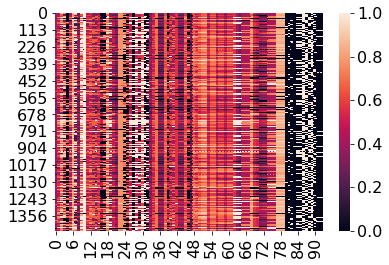

In [54]:
sns.heatmap(X_fit)

plt.show()

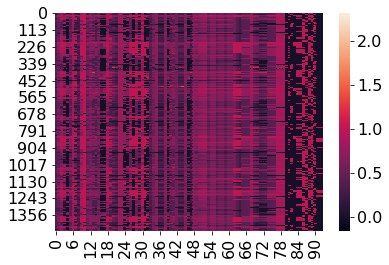

In [55]:
sns.heatmap(X_submit)
plt.show()

In [58]:
test.index

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919],
           dtype='int64', name='Id', length=1459)

In [61]:
df_submit = pd.DataFrame({'Id':test.index,
                          'SalePrice':np.expm1(reg.predict(X_submit))})
df_submit.set_index('Id',inplace=True)

In [63]:
df_submit.to_csv('./submission.csv')